___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fassets-global.website-files.com%2F5e5d43546b94f97f39c228fa%2F62f4ee3b1b9187fdf2f03923_How_to_Write_a_Movie_Review__Step-by-Step_Guide.png&f=1&nofb=1&ipt=c0d6c1b5f79bba90a6b43bf0240e8edb7414d5fdb6c7cd9599cc5c4168b922fa" width="300px" height="180px" />


# <font color= #bbc28d> **Sentiment Analysis in Movies IMDb** </font>
#### <font color= #2E9AFE> `Project 1 – Text Mining`</font>
- <Strong> Sofía Maldonado, Diana Valdivia & Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 28/09/2025 

___

<p style="text-align:right;"> Imagen recuperada de: https://essaypro.com/blog/movie-review</p>

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# For tokenization
import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, wordnet, WordNetLemmatizer
import string

# For vectorizing
from sklearn.feature_extraction.text import CountVectorizer

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# <font color= #bbc28d> **Preprocessing** </font>

In [2]:
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vivienne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vivienne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vivienne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('imdb_reviews.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# Tools for pre-processing
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

In [5]:
# Function for making the tokens. Takes into account that words are not punctuation, stop words, lemmatizing AND if they are fully uppercase which may be important to know
def making_tokens(text: str):
    text = text.replace('<br />', " ") # Removing line break characters so they aren't counted as tokens
    tokens = word_tokenize(text)
    processed = []
    for i in tokens:
        if i.lower() not in stop_words and i not in punctuation:
            if i.isupper() and len(i) > 1:
                processed.append(i.lower() + '_UPPER') # Because a word being all uppercase (like "us" vs "US") can be relevant information.
            else:
                processed.append(lemmatizer.lemmatize(i.lower()))
    
    return processed

In [6]:
df['tokens'] = df['review'].apply(making_tokens)

In [7]:
df

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mentioned, watching, 1, oz, ep..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,"[basically, 's, family, little, boy, jake, thi..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, 's, ``, love, time, money, ''..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,"[thought, movie, right, good, job, n't, creati..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,"[catholic, taught, parochial, elementary, scho..."
49998,I'm going to have to disagree with the previou...,negative,"['m, going, disagree, previous, comment, side,..."


In [8]:
# Since the original dataset is said to have 25,000 train and 25,000 test reviews, the splits will be 50-25-25 for train-dev-test respectively

x = df['tokens']
y = df['sentiment']

X_train, X_temp, Y_train, Y_temp = train_test_split(x, y, test_size=0.5, random_state=42)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train dataset size: {X_train.shape[0]} reviews")
print(f"Dev dataset size: {X_dev.shape[0]} reviews")
print(f"Test dataset size: {X_test.shape[0]} reviews")

Train dataset size: 25000 reviews
Dev dataset size: 12500 reviews
Test dataset size: 12500 reviews


In [9]:
# Turns the lists of tokens into singular strings of words, to work with in the models
X_train_text = X_train.apply(lambda x: " ".join(x))
X_dev_text = X_dev.apply(lambda x: " ".join(x))
X_test_text = X_test.apply(lambda x: " ".join(x))

# <font color= #bbc28d> **Feature Extraction** </font>

In [10]:
# CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train_text)

X_dev_vectorized = vectorizer.transform(X_dev_text)
X_test_vectorized = vectorizer.transform(X_test_text)

In [11]:
ngrams = vectorizer.get_feature_names_out()
#print(ngrams[:50])

row = X_train_vectorized[0].toarray().ravel()
present_ngrams = [ngrams[i] for i in range(len(ngrams)) if row[i] > 0]
print(present_ngrams)


['act', 'act like', 'actor', 'actor film', 'actor movie', 'african', 'air', 'also', 'although', 'always', 'awful', 'bad', 'baker', 'based', 'best', 'book', 'boring', 'campy', 'character', 'charm', 'cheesy', 'cia_upper', 'compared', 'completely', 'computer', 'constantly', 'contact', 'could', 'creature', 'dangerous', 'daughter', 'day', 'deeply', 'dialogue', 'diamond', 'direction', 'disappointed', 'disaster', 'discover', 'eccentric', 'effect', 'end', 'enjoyable', 'enough', 'escape', 'especially', 'even', 'film', 'film plot', 'former', 'freak', 'function', 'go', 'horror', 'hudson', 'in', 'in law', 'including', 'joe', 'john', 'jones', 'king', 'lacked', 'large', 'laura', 'law', 'life', 'like', 'looking', 'lost', 'michael', 'mine', 'missile', 'morality', 'movie', 'movie also', 'movie even', 'nothing', 'novel', 'often', 'one', 'one worst', 'pathetic', 'picture', 'plain', 'plot', 'powerful', 'problem', 'production', 'prof', 'punch', 'pure', 'quality', 'quest', 'reminded', 'ridiculous', 'rocky',

# <font color= #bbc28d> **1. Logistic Regression** </font>

In [12]:
# LOGISITC REGRESSION

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vectorized, Y_train)

LogisticRegression(max_iter=1000)

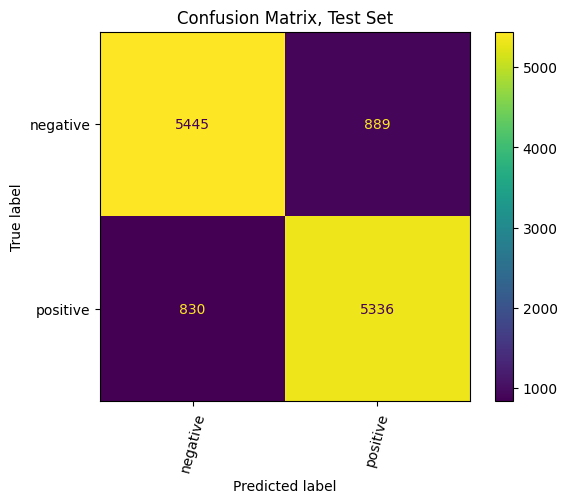

In [13]:
Y_dev_pred = lr.predict(X_dev_vectorized)

cm = confusion_matrix(Y_dev, Y_dev_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot()
plt.xticks(rotation = 75)
plt.title("Confusion Matrix, Test Set")
plt.show()

In [14]:
print(classification_report(Y_dev, Y_dev_pred, digits=5))

              precision    recall  f1-score   support

    negative    0.86773   0.85965   0.86367      6334
    positive    0.85719   0.86539   0.86127      6166

    accuracy                        0.86248     12500
   macro avg    0.86246   0.86252   0.86247     12500
weighted avg    0.86253   0.86248   0.86249     12500



# <font color= #bbc28d> **2. Naive Bayes** </font>

# <font color= #bbc28d> **3. Support Vector Classifier** </font>

Linear Kernel 

RBF Kernel